In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import legendre

If you're encoding data using and LDN/LMU then you might want to know how much information you are losing based on your choice of theta and q.  Since the LDN is linear, one way to do that would be to make a Bode plot showing the effects of the encoding.  This would indicate what frequencies are kept and what ones are attenuated due to the encoding process.

Let's try implemting this approach.  For simplicity, the work here is based on assuming that the LDN encodes Lengendre polynomials exactly, which is pretty close, although we might want to actually try soing this same approach with the real discretized A matrix instead.

First, let's make the Legendre polynomials

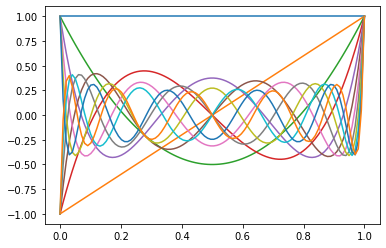

In [321]:
q = 12
theta = 100
r = np.linspace(0, 1, theta)
leg = np.asarray([legendre(i)(2*r - 1) for i in range(q)])
plt.plot(r, leg.T)
plt.show()

The Legendre polynomials are how we decode the data from on LDN.  But we want to know what happens during encoding.  In the ideal continuous case, the encoding would also be the Legendre polynomials, except scaled by $1/(2i+1)$.  This is because the Legendre polynomials are an *orthoganal* basis space, but not an *orthonormal* basis space (if they were orthonormal, the scaling factors would all be 1).  

But, in addition to this scaling factor, there's also the fact that we're working with discrete data rather than continuous time, so to take care of that as well as the scaling factor, let's just find the encoding matrix by just computing the pseudo-inverse of the Legendre polynomial matrix.  This tells us what everything is being encoding by during the LDN process.

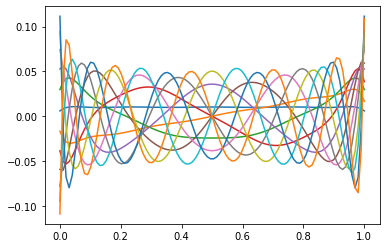

In [322]:
leg_inv = np.linalg.pinv(leg).T
plt.plot(r, leg_inv.T)
plt.show()

Now we take their Fourier transform.  This will tell us what frequency components are encoded in each of our q basis functions.

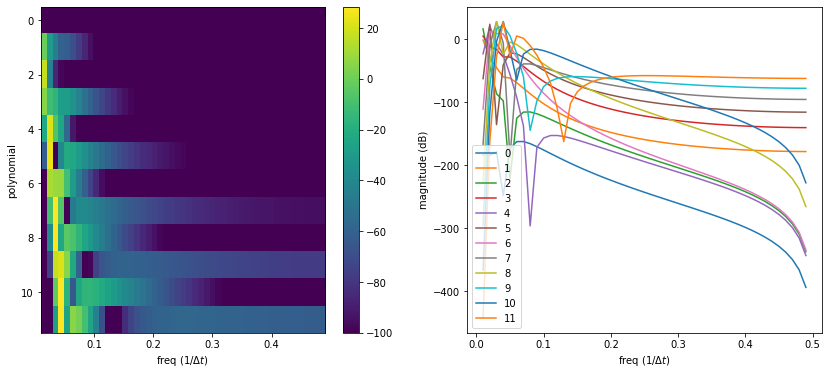

In [323]:
F = numpy.fft.fft(leg_inv)[:,1:theta//2]   # slicing to remove the DC term and the negative frequencies
freq = np.fft.fftfreq(theta)[1:theta//2]

P = np.abs(F)**2    # square it to get the power
db = np.log(P)*20   # convert to decibels

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(db, extent=(freq[0], freq[-1], q-0.5, -0.5), aspect='auto', vmin=-100)
plt.xlabel('freq ($1/\Delta t$)')
plt.ylabel('polynomial')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.plot(freq, db.T)
plt.ylabel('magnitude (dB)')
plt.xlabel('freq ($1/\Delta t$)')
plt.legend([f'{i}' for i in range(q)])
plt.show()

But that tells us what each individual basis function does as a filter, not what the LDN as a whole does.  In order to get that, we need to decode out of the LDN by weighting each of these components.  To do this, we need to pick a set of weights.  To get a set of weights we need to choose a particular point in time about that past that we're going to try to decode.  Let's pick the point 80% of the way through the window (`theta*0.8`)

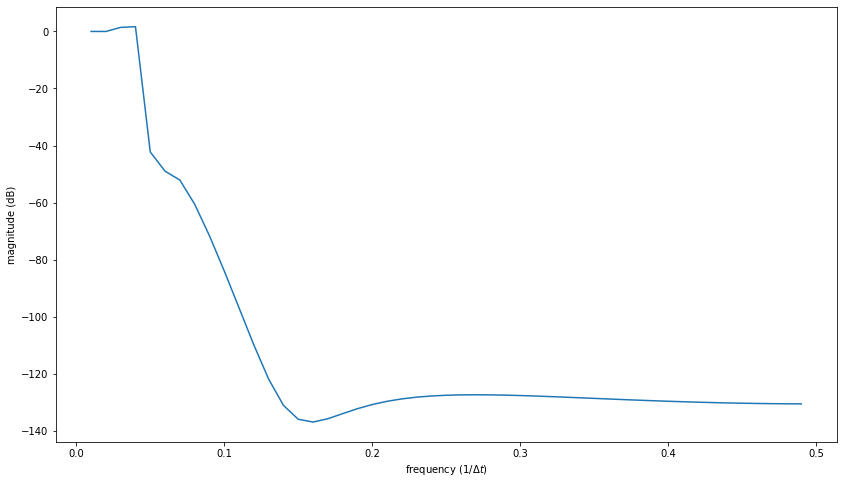

In [327]:
dec = leg[:, int(theta*0.8)]

Fdec = np.dot(dec, F)

Pdec = np.abs(Fdec)**2    # square it to get the power
dbdec = np.log(Pdec)*20   # convert to decibels

plt.figure(figsize=(14,8))
plt.plot(freq, dbdec)
plt.ylabel('magnitude (dB)')
plt.xlabel('frequency ($1/\Delta t$)')
plt.show()

That looks great!  For the lower frequencies, the Bode plot is flat, indicating that we're not attenuating anything.  Past a certain frequency, the magnitude drops drastically.  The normal "cutoff" point for a Bode plot is when it hits -3dB.  Let's find that point.

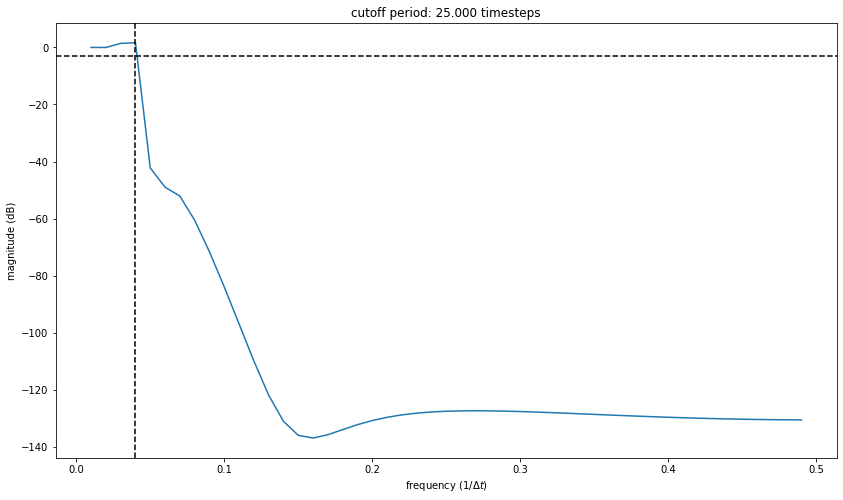

In [328]:
plt.figure(figsize=(14,8))
plt.plot(freq, dbdec)
plt.ylabel('magnitude (dB)')
plt.axhline(-3, ls='--', c='k') # cutoff frequency is normally considered -3dB

cutoff_index = np.where(dbdec<=-3)[0][0] 
cutoff = freq[cutoff_index-1]

plt.axvline(cutoff, ls='--', c='k')

cutoff_period = 1/cutoff
plt.title(f'cutoff period: {cutoff_period:.3f} timesteps')
plt.xlabel('frequency ($1/\Delta t$)')
plt.show()

This indicates that an LDN with q=12 and theta=100 is good at representing sine waves with periods of up to 25 timesteps, but any higher frequency signals will be lost.

Now that we have this result, let's make it a function and try some different q and theta values.

In [336]:
def compute_ldn_bode(q, theta, decode_point=0.5):
    r = np.linspace(0, 1, theta)
    leg = np.asarray([legendre(i)(2*r - 1) for i in range(q)])
    leg_inv = np.linalg.pinv(leg).T
    F = numpy.fft.fft(leg_inv)[:,1:theta//2]   # slicing to remove the DC term and the negative frequencies
    freq = np.fft.fftfreq(theta)[1:theta//2]
    dec = leg[:, int(decode_point*theta)]    # decode from the midpoint in the window

    Fdec = np.dot(dec, F)

    Pdec = np.abs(Fdec)**2    # square it to get the power
    dbdec = np.log(Pdec)*20   # convert to decibels
    return freq, dbdec




    

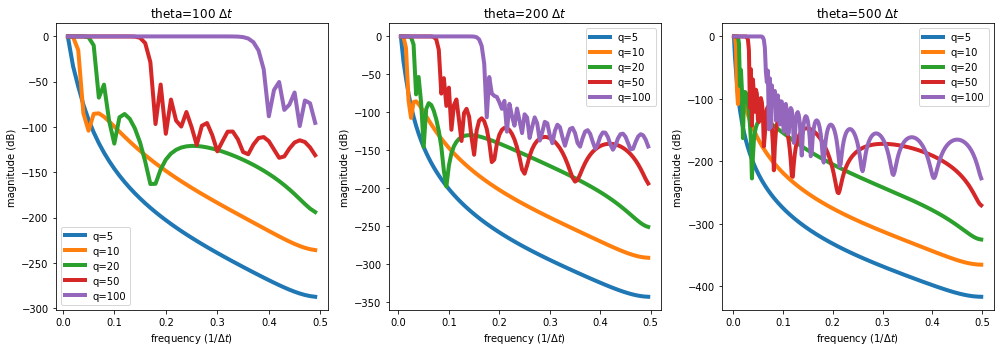

In [340]:
plt.figure(figsize=(14,5))

for i,theta in enumerate([100, 200, 500]):
    plt.subplot(1, 3, i+1)
    plt.title(f'theta={theta} $\Delta t$')
    for q in [5, 10, 20, 50, 100]:
        freq, db = compute_ldn_bode(q=q, theta=theta)
        plt.plot(freq, db, label=f'q={q}', lw=4)
    plt.legend()
    plt.ylabel('magnitude (dB)')
    plt.xlabel('frequency ($1/\Delta t$)')
plt.tight_layout()
plt.show()

        


Those plots go really far into the negatives, and the shape there does really matter, as anything attenuated by more that -40dB is 100x smaller than it was before, so let's cut off our plots there.

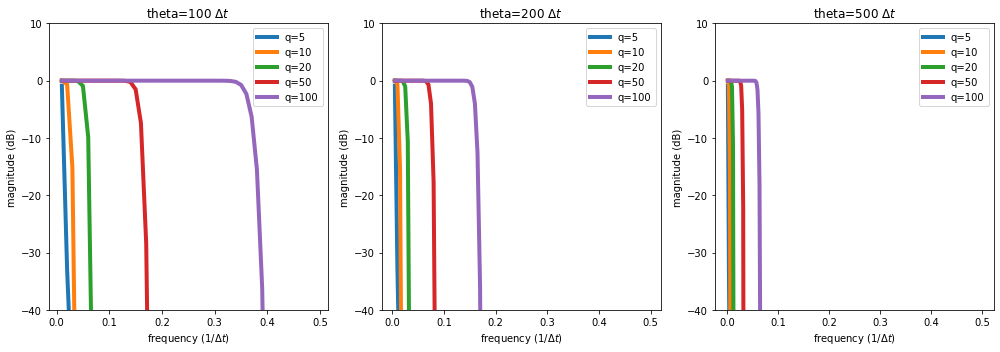

In [343]:
plt.figure(figsize=(14,5))

for i,theta in enumerate([100, 200, 500]):
    plt.subplot(1, 3, i+1)
    plt.title(f'theta={theta} $\Delta t$')
    for q in [5, 10, 20, 50, 100]:
        freq, db = compute_ldn_bode(q=q, theta=theta)
        plt.plot(freq, db, label=f'q={q}', lw=4)
    plt.legend()
    plt.ylabel('magnitude (dB)')
    plt.xlabel('frequency ($1/\Delta t$)')
    plt.ylim(-40,10)
plt.tight_layout()
plt.show()

        


Success!  We can now see what sorts of frequencies are being encoded by our LDN.